<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/tim-lr-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [1]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
repo_path = '/content/drive/MyDrive/milestone-ii/'
train_path = ''.join([repo_path, 'Training_set.csv'])
test_path = ''.join([repo_path, 'Testing_set.csv'])

df_train = pd.read_csv(train_path, sep='\t', index_col=0)
df_test = pd.read_csv(test_path, sep='\t', index_col=0)

df_train.head(1)

,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
91224,For instance the number of k-permutations of n...,4.5427,5.14,3.94,9.57,2.5775,1.43,4.55,12.0,1


In [3]:
num_features = ['d_chall_score', 'aoa_max', 'num_lemmas']

text_features = 'lemmatized_text'

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
    # I'm going to try binning to speed convergence while using
    # heterogeneous features (dense numeric values and sparse tfidf vectors)
    ('binner', KBinsDiscretizer(n_bins=4)),
])

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('text', text_pipe, text_features),
])

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression())
])

In [4]:
sample_df = df_train.groupby('label').apply(lambda grp: grp.sample(25000, random_state=99))

Lets do a grid search to find optimal hyper-parameters

In [12]:
# When using a pipeline in grid search, you can prepend the parameter
# you want to tune with the pipeline component name (clf) and two underscores (__).
tfidf_prefix = 'preprocessor__text__tfidf__'
clf_prefix = 'clf__'

param_grid = {tfidf_prefix + 'min_df':[50],
              tfidf_prefix + 'ngram_range':[(1, 3)],
              tfidf_prefix + 'min_df':[50],
              clf_prefix + 'C':[.2, .5, 1], 
              clf_prefix + 'penalty':['l1', 'l2'],
              clf_prefix + 'solver':['saga'],
              clf_prefix + 'random_state':[99],
              clf_prefix + 'n_jobs':[-1],}

grid = (GridSearchCV(clf, 
                    param_grid=param_grid,
                    scoring='accuracy', 
                    cv=StratifiedKFold(n_splits=10),
                    refit=False,
                    verbose=1,
                    return_train_score=True,
                    n_jobs=-1)
        .fit(sample_df, sample_df['label']))

In [9]:
print(grid.best_params_)
pd.DataFrame(grid.cv_results_).T

{'clf__C': 0.5, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 99, 'clf__solver': 'saga', 'preprocessor__text__tfidf__min_df': 50, 'preprocessor__text__tfidf__ngram_range': (1, 3)}


,0,1,2,3,4,5
mean_fit_time,11.036908,4.406783,15.342028,3.64449,16.952381,3.643021
std_fit_time,1.644964,0.266251,0.73807,0.054009,0.863077,0.071308
mean_score_time,0.210388,0.211391,0.296846,0.223818,0.232346,0.207644
std_score_time,0.021186,0.011114,0.124216,0.014492,0.076508,0.006102
param_clf__C,0.2,0.2,0.5,0.5,1,1
param_clf__n_jobs,-1,-1,-1,-1,-1,-1
param_clf__penalty,l1,l2,l1,l2,l1,l2
param_clf__random_state,99,99,99,99,99,99
param_clf__solver,saga,saga,saga,saga,saga,saga
param_preprocessor__text__tfidf__min_df,50,50,50,50,50,50


Build a new model using best params

In [21]:
tfidf_best_params = {k[len(tfidf_prefix):]:v 
                     for (k, v) in grid.best_params_.items() 
                     if tfidf_prefix in k}

clf_best_params = {k[len(clf_prefix):]:v 
                   for (k, v) in grid.best_params_.items() 
                   if clf_prefix in k}

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
    # I'm going to try binning to speed convergence while using
    # heterogeneous features (dense numeric values and sparse tfidf vectors)
    ('binner', KBinsDiscretizer(n_bins=4)),
])

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_best_params)),
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('text', text_pipe, text_features),
])

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(**clf_best_params)),
])

Final test on our training data to see if our model is overfitting.

In [78]:
X_train, X_val, y_train, y_val = train_test_split(df_train[num_features + [text_features]], 
                                                  df_train['label'],
                                                  stratify=df_train['label'], 
                                                  random_state=99)

clf = clf.fit(X_train, y_train)

train_y_proba = clf.predict_proba(X_train)[:, 1]
train_y_hat = clf.predict(X_train)

val_y_proba = clf.predict_proba(X_val)[:, 1]
val_y_hat = clf.predict(X_val)

train_roc_auc = metrics.roc_auc_score(y_train, train_y_proba)
train_accuracy = metrics.accuracy_score(y_train, train_y_hat)
train_f1 = metrics.f1_score(y_train, train_y_hat)
train_precision = metrics.precision_score(y_train, train_y_hat)
train_recall = metrics.recall_score(y_train, train_y_hat)

val_roc_auc = metrics.roc_auc_score(y_val, val_y_proba)
val_accuracy = metrics.accuracy_score(y_val, val_y_hat)
val_f1 = metrics.f1_score(y_val, val_y_hat)
val_precision = metrics.precision_score(y_val, val_y_hat)
val_recall = metrics.recall_score(y_val, val_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Validation ROC AUC:', val_roc_auc)
print('Validation Accuracy Score:', val_accuracy)
print('Validation F1 Score:', val_f1)
print('Validation Precision Score:', val_precision)
print('Validation Recall Score:', val_recall)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



Train ROC AUC: 0.7930625447062772
Train Accuracy Score: 0.7170979871709798
Train F1 Score: 0.7334503696534478
Train Precision Score: 0.7175359904900789
Train Recall Score: 0.7500866976851718

Validation ROC AUC: 0.7749621296339275
Validation Accuracy Score: 0.7018996097308605
Validation F1 Score: 0.7199771798041267
Validation Precision Score: 0.7023250061835271
Validation Recall Score: 0.7385395669419338


In [79]:
# Get transformed feature names.
num_features_trf = (clf['preprocessor']
                    .transformers_[0][1]
                    ['binner']
                    .get_feature_names_out(num_features))

text_features_trf = (clf['preprocessor']
                 .transformers_[1][1]
                 ['tfidf']
                 .get_feature_names_out())

all_features_trf = list(num_features_trf) + list(text_features_trf)

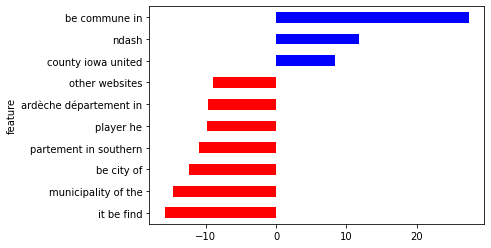

In [80]:
df_coef = pd.DataFrame({'feature':all_features_trf, 
                        'coef':clf['clf'].coef_[0],
                        'abscoef':np.abs(clf['clf'].coef_[0]),
                        'is_positive':clf['clf'].coef_[0] >= 0})
# What are top 10 most important features
def plot_top_10(df_plot):
  df_plot = (df_plot
    .sort_values('abscoef', ascending=False)
    .head(10)
    .sort_values('coef'))
  df_plot.plot.barh('feature', 'coef', 
                    color=df_plot.is_positive.map({True:'b', False:'r'}), 
                    legend=None)

plot_top_10(df_coef)

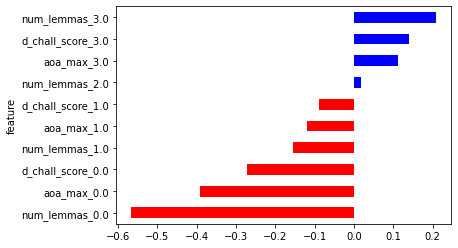

In [81]:
# Just how important are our MADS features
def plot_top_10_mads(df_plot):
  df_plot = (df_plot[df_plot.feature.isin(num_features_trf)]
    .sort_values('abscoef', ascending=False)
    .head(10)
    .sort_values('coef'))
  
  df_plot.plot.barh('feature', 'coef', 
                    color=df_plot.is_positive.map({True:'b', False:'r'}),
                    legend=None)
  
plot_top_10_mads(df_coef)

## Final test

In [82]:
clf = clf.fit(df_train, df_train['label'])

train_y_proba = clf.predict_proba(df_train)[:, 1]
train_y_hat = clf.predict(df_train)

test_y_proba = clf.predict_proba(df_test)[:, 1]
test_y_hat = clf.predict(df_test)

train_roc_auc = metrics.roc_auc_score(df_train['label'], train_y_proba)
train_accuracy = metrics.accuracy_score(df_train['label'], train_y_hat)
train_f1 = metrics.f1_score(df_train['label'], train_y_hat)
train_precision = metrics.precision_score(df_train['label'], train_y_hat)
train_recall = metrics.recall_score(df_train['label'], train_y_hat)

test_roc_auc = metrics.roc_auc_score(df_test['label'], test_y_proba)
test_accuracy = metrics.accuracy_score(df_test['label'], test_y_hat)
test_f1 = metrics.f1_score(df_test['label'], test_y_hat)
test_precision = metrics.precision_score(df_test['label'], test_y_hat)
test_recall = metrics.recall_score(df_test['label'], test_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Test ROC AUC:', test_roc_auc)
print('Test Accuracy Score:', test_accuracy)
print('Test F1 Score:', test_f1)
print('Test Precision Score:', test_precision)
print('Test Recall Score:', test_recall)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



Train ROC AUC: 0.7964591780955743
Train Accuracy Score: 0.7203924060598562
Train F1 Score: 0.7359558169483424
Train Precision Score: 0.7215540491289453
Train Recall Score: 0.7509441936829785

Test ROC AUC: 0.7777621987194598
Test Accuracy Score: 0.7040514209074575
Test F1 Score: 0.7211160128770716
Test Precision Score: 0.7055858882822343
Test Recall Score: 0.7373451672681166


Lets save our final model

In [83]:
import joblib

model_path = ''.join([repo_path, 'logistic-regression-clf.joblib'])

joblib.dump(clf, model_path)

['/content/drive/MyDrive/milestone-ii/logistic-regression-clf.joblib']